### Import libraries

In [3]:
!pip install datasets evaluate nltk sentence-transformers detoxify

import torch
from torch.utils.data import DataLoader, Dataset
from transformers import T5ForConditionalGeneration, T5Tokenizer, AdamW
from torch.cuda.amp import autocast, GradScaler
import logging
import os
import matplotlib.pyplot as plt
import evaluate
import numpy as np
from sentence_transformers import SentenceTransformer
from detoxify import Detoxify
from datasets import load_dataset as hf_load_dataset
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.3 MB/s eta 0:00:00


### **File 1: dataset.py**

In [4]:
def read_dataset(tsv_path: str):
    dataset = hf_load_dataset("csv", data_files=tsv_path, delimiter="\t", split="train")
    return dataset

class DetoxificationDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, max_length: int = 128):
        self.dataset = hf_dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        toxic_text = item["toxic"]
        neutral_text = item.get("neutral1") or item.get("neutral2") or item.get("neutral3")
        prompt = "detoxify text: "
        toxic_text_with_prompt = prompt + toxic_text

        input_encodings = self.tokenizer(
            toxic_text_with_prompt,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        target_encodings = self.tokenizer(
            neutral_text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        
        input_ids = input_encodings["input_ids"].squeeze()
        attention_mask = input_encodings["attention_mask"].squeeze()
        labels = target_encodings["input_ids"].squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100
        
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "toxic_text": toxic_text
        }

def split_dataset(tsv_path: str, eval_size: int = 1962, seed: int = 42):
    full_dataset = read_dataset(tsv_path)
    dataset_len = len(full_dataset)
    if dataset_len < eval_size:
        raise ValueError("Dataset has fewer samples than the requested evaluation size.")
    eval_fraction = eval_size / dataset_len
    splits = full_dataset.train_test_split(test_size=eval_fraction, seed=seed)
    return splits["train"], splits["test"]

def create_dataloader(tsv_path: str, tokenizer, batch_size: int = 16, max_length: int = 128, seed: int = 42, eval_size: int = 1962):
    train_dataset, eval_dataset = split_dataset(tsv_path, eval_size=eval_size, seed=seed)
    train_data = DetoxificationDataset(train_dataset, tokenizer, max_length)
    eval_data = DetoxificationDataset(eval_dataset, tokenizer, max_length)
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    eval_dataloader = DataLoader(eval_data, batch_size=batch_size, shuffle=False)
    return train_dataloader, eval_dataloader

### **File 2: logging_utils.py**

In [5]:
def setup_logger(log_file: str = "training.log"):
    logger = logging.getLogger("training_logger")
    logger.setLevel(logging.INFO)
    if logger.hasHandlers():
        logger.handlers.clear()
    fh = logging.FileHandler(log_file)
    fh.setLevel(logging.INFO)
    ch = logging.StreamHandler()
    ch.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)
    logger.addHandler(fh)
    logger.addHandler(ch)
    return logger

def log_metrics(logger, step: int, metrics: dict):
    message = f"Step {step}: " + ", ".join([f"{key}: {value:.4f}" for key, value in metrics.items()])
    logger.info(message)

def plot_metric(metric_values: list, metric_name: str, save_dir: str = None):
    plt.figure(figsize=(8, 6))
    plt.plot(metric_values, marker='o', linestyle='-', color='b')
    plt.title(f"{metric_name} over Training Steps")
    plt.xlabel("Step/Epoch")
    plt.ylabel(metric_name)
    plt.grid(True)
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f"{metric_name}_plot.png")
        plt.savefig(save_path)
        print(f"Saved {metric_name} plot to {save_path}")
    plt.show()

def plot_losses(train_losses: list, eval_losses: list, save_dir: str = None):
    plt.figure(figsize=(8, 6))
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, marker='o', linestyle='-', label="Training Loss", color='r')
    plt.plot(epochs, eval_losses, marker='o', linestyle='-', label="Evaluation Loss", color='g')
    plt.title("Training and Evaluation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, "loss_plot.png")
        plt.savefig(save_path)
        print(f"Saved loss plot to {save_path}")
    plt.show()

### **File 3: split_dataset.py**

In [6]:
def split_tsv(input_file, train_file, eval_file, eval_size=1962, random_seed=42):
    df = pd.read_csv(input_file, sep="\t")
    eval_df = df.sample(n=eval_size, random_state=random_seed)
    train_df = df.drop(eval_df.index)
    train_df.to_csv(train_file, sep="\t", index=False)
    eval_df.to_csv(eval_file, sep="\t", index=False)
    print(f"Saved {len(train_df)} training samples to {train_file}")
    print(f"Saved {len(eval_df)} evaluation samples to {eval_file}")

### **File 4: model.py**

In [7]:
def load_t5(model_name: str = "t5-base"):
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name)
    return model, tokenizer

### **File 5: metrics.py**

In [23]:
!pip install sacrebleu
# Latest version of nltk
!pip install -U nltk
from sentence_transformers import util

bleu = evaluate.load("sacrebleu")
meteor = evaluate.load("meteor")

def compute_bleu(predictions, references):
    results = bleu.compute(predictions=predictions, references=[[ref] for ref in references])
    return results["score"]

def compute_meteor(predictions, references):
    results = meteor.compute(predictions=predictions, references=references)
    return results["meteor"]

def compute_content_preservation(original_texts, generated_texts, embedding_model=None):
    if embedding_model is None:
        embedding_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")
    orig_embeddings = embedding_model.encode(original_texts, convert_to_tensor=True)
    gen_embeddings = embedding_model.encode(generated_texts, convert_to_tensor=True)
    cosine_scores = util.cos_sim(orig_embeddings, gen_embeddings)
    diag_sim = cosine_scores.diag().cpu().numpy()
    return np.mean(diag_sim)

def compute_all_metrics(predictions, references, original_texts=None):
    metrics = {}
    metrics["bleu"] = compute_bleu(predictions, references)
    metrics["meteor"] = compute_meteor(predictions, references)
    if original_texts is not None:
        metrics["content_preservation"] = compute_content_preservation(original_texts, predictions)
    else:
        metrics["content_preservation"] = None
    return metrics

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### **Training and Evaluation**

### Setup Logger

In [24]:
logger = setup_logger("/kaggle/working/training.log")

### Load model and tokenizer

In [25]:
model, tokenizer = load_t5("t5-base")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

### Load data

In [26]:
tsv_path = "/kaggle/input/paradetox/paradetox.tsv"
train_loader, eval_loader = create_dataloader(tsv_path, tokenizer, 
                                              batch_size=16, max_length=128, eval_size=1962)

### Optimizer and scaler

In [27]:
optimizer = AdamW(model.parameters(), lr=3e-5)
scaler = GradScaler()

<ipython-input-27-9019933e5337>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


### Training Loop

In [28]:
num_epochs = 3
train_losses = []
eval_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        with autocast():
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            train_loss += loss.item()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    eval_loss = 0
    predictions = []
    references = []
    original_texts = []
    with torch.no_grad():
        for batch in eval_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            eval_loss += outputs.loss.item()
            
            preds = model.generate(input_ids=input_ids, attention_mask=attention_mask,
                                   max_length=128, num_beams=4, early_stopping=True)
            pred_texts = [tokenizer.decode(p, skip_special_tokens=True) for p in preds]
            ref_texts = [tokenizer.decode(l[(l != tokenizer.pad_token_id) & (l != -100)], 
                                          skip_special_tokens=True) for l in labels]
            orig_texts = batch["toxic_text"]
            
            predictions.extend(pred_texts)
            references.extend(ref_texts)
            original_texts.extend(orig_texts)
    
    avg_eval_loss = eval_loss / len(eval_loader)
    eval_losses.append(avg_eval_loss)
    
    # Compute metrics
    metrics = compute_all_metrics(predictions, references, original_texts)
    log_metrics(logger, epoch + 1, {"train_loss": avg_train_loss, 
                                    "eval_loss": avg_eval_loss, **metrics})

<ipython-input-28-2c86be23c3a4>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

2025-03-30 14:37:28,446 - INFO - Step 1: train_loss: nan, eval_loss: 0.9387, bleu: 54.9532, meteor: 0.7501, content_preservation: 0.8903


Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

2025-03-30 14:44:29,525 - INFO - Step 2: train_loss: nan, eval_loss: 0.8974, bleu: 54.5646, meteor: 0.7642, content_preservation: 0.8895


Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

2025-03-30 14:51:29,550 - INFO - Step 3: train_loss: nan, eval_loss: 0.8863, bleu: 55.2660, meteor: 0.7603, content_preservation: 0.8833


### Save model

In [29]:
model.save_pretrained("/kaggle/working/t5_detox_model")

### Plot losses

Saved loss plot to /kaggle/working/plots/loss_plot.png


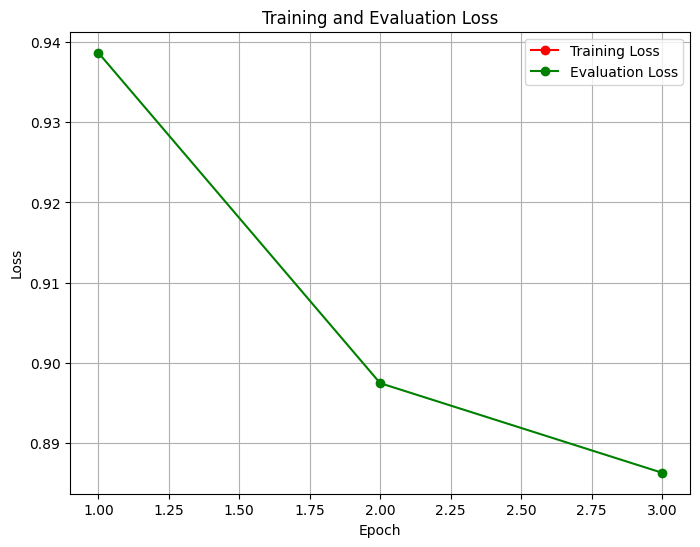

In [30]:
plot_losses(train_losses, eval_losses, save_dir="/kaggle/working/plots")

### Plot metrics

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Saved BLEU plot to /kaggle/working/plots/BLEU_plot.png


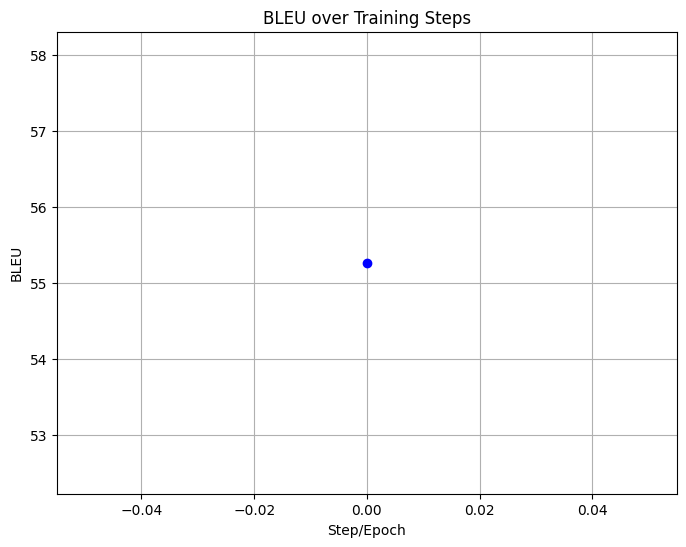

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Saved METEOR plot to /kaggle/working/plots/METEOR_plot.png


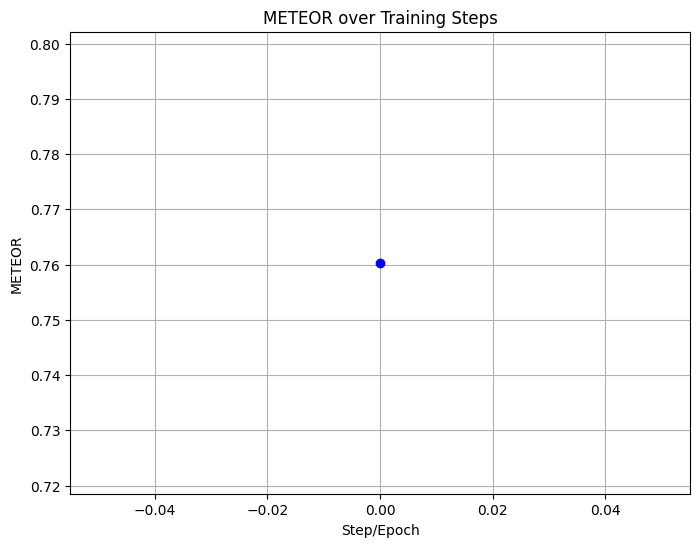

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Saved Content Preservation plot to /kaggle/working/plots/Content Preservation_plot.png


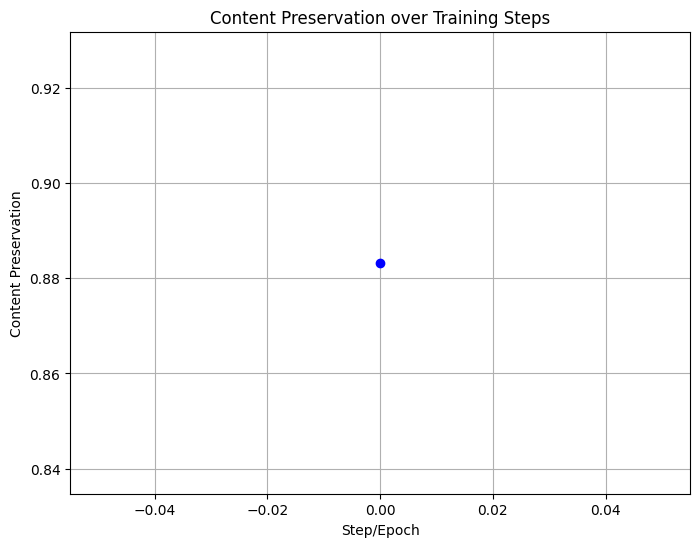

In [31]:
plot_metric([m["bleu"] for m in [compute_all_metrics(predictions, references, original_texts)]], "BLEU", save_dir="/kaggle/working/plots")
plot_metric([m["meteor"] for m in [compute_all_metrics(predictions, references, original_texts)]], "METEOR", save_dir="/kaggle/working/plots")
plot_metric([m["content_preservation"] for m in [compute_all_metrics(predictions, references, original_texts)]], "Content Preservation", save_dir="/kaggle/working/plots")